# Lab 5 - Image Restoration

## Goal: Introduction to image restoration

Import the necessary libraries

In [2]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform,io,util,img_as_float
from skimage import restoration
import cv2
from skimage.util import random_noise

Load image and add blurring and noise:

In [3]:
# The function return two images: a blurred image 
# and an image after blurring and noise adding
def AddBlurreAndNoise(img, filter_blur):
    kernel_matrix = np.ones((5,5), np.float64)/25
    img_blurre=cv2.filter2D(img, -1, kernel_matrix)
    img_blurre_noise = random_noise(img_blurre)
    
    return img_blurre, img_blurre_noise
    

Image shape:(512L, 512L), Image data type:float64


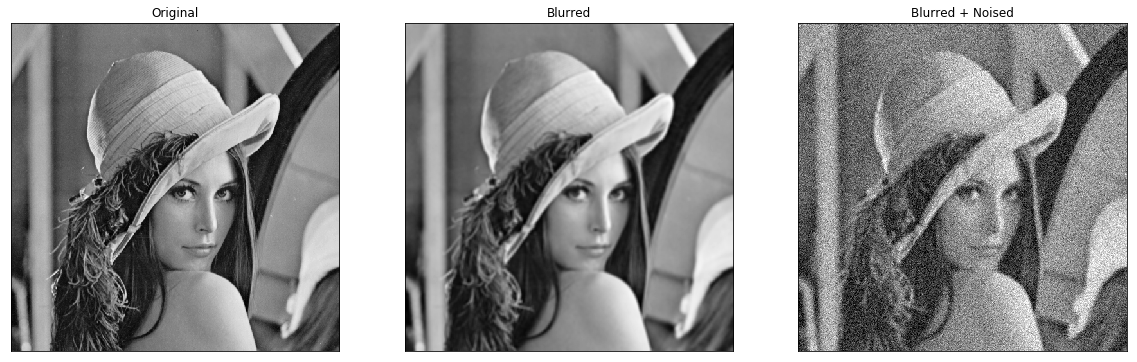

In [4]:
img = io.imread('lena.gif')
img = img_as_float(img)
print ("Image shape:{}, Image data type:{}".format(img.shape,img.dtype))
# Use gaussian kernel for burring the image
# gaussian kernel is separable function
filter_blur = cv2.getGaussianKernel(ksize=5,sigma=1.85)*cv2.getGaussianKernel(ksize=5,sigma=1.85).T 

blurred, noise = AddBlurreAndNoise(img,filter_blur)

plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(blurred, cmap='gray'),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(noise, cmap='gray'),plt.title('Blurred + Noised')
plt.xticks([]), plt.yticks([])
plt.show()

###  Part 1 - Inverse Filter

1. Test the restoration with the Inverse Filter for deblurring and denoising

In [5]:
def InvertFilter(noise_img,filter_blur):
    n,m = noise_img.shape  ##get size of image
    H_shifted = (np.fft.fft2(filter_blur,s=(n,m)))
    H_inverse = np.power(H_shifted,-1)
    denoise_img_freq = (np.fft.fft2(noise_img)) * H_inverse
    denoise_img = np.abs(np.fft.ifft2(denoise_img_freq))

    return denoise_img
    

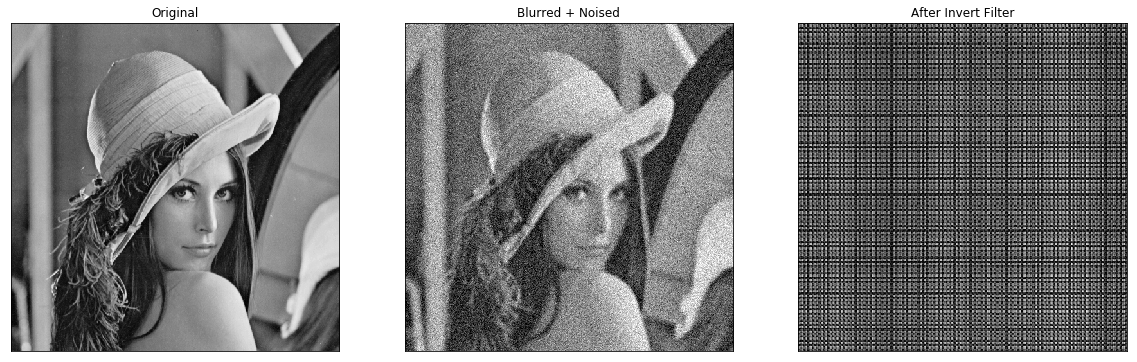

In [6]:
denoise_Invert_img = InvertFilter(noise,filter_blur)

plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(noise, cmap='gray'),plt.title('Blurred + Noised')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(denoise_Invert_img, cmap='gray'),plt.title('After Invert Filter')
plt.xticks([]), plt.yticks([])
plt.show()

2. What is the problem with the Inverse Filter? How can this be solved?

```
# the problem is that the output image is very unclear due to increasion of noise. can be solved by using psuedo inverse filter, or by filtering out the noise before activating inverse filter.
```

### Part 2 - Pseudo Inverse Filter

1. Test the restoration with the Pseudo Inverse Filter for deblurring and denoising

In [7]:
def PseudoInvertFilter(noise_img, filter_blur, epsilon):
    m,n = noise_img.shape
    H_Pseudo_Inverse = np.zeros((n,m))
    noisy_img_FFT = np.fft.fft2(noise_img)
    H = np.fft.fft2(filter_blur, s=(n, m))
    for i in range(m):
        for j in range(n):
            if np.abs(H[i,j])>epsilon:
                H_Pseudo_Inverse[i, j] = 1 / H[i, j]
    multiplication_with_inverse_pseudo_filter = H_Pseudo_Inverse * noisy_img_FFT
    iFFT_img = np.fft.ifft2(multiplication_with_inverse_pseudo_filter)
    denoise_img = np.abs(iFFT_img)
    return denoise_img
    

C:\Users\matan\Anaconda2\envs\bluebanana\lib\site-packages\ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


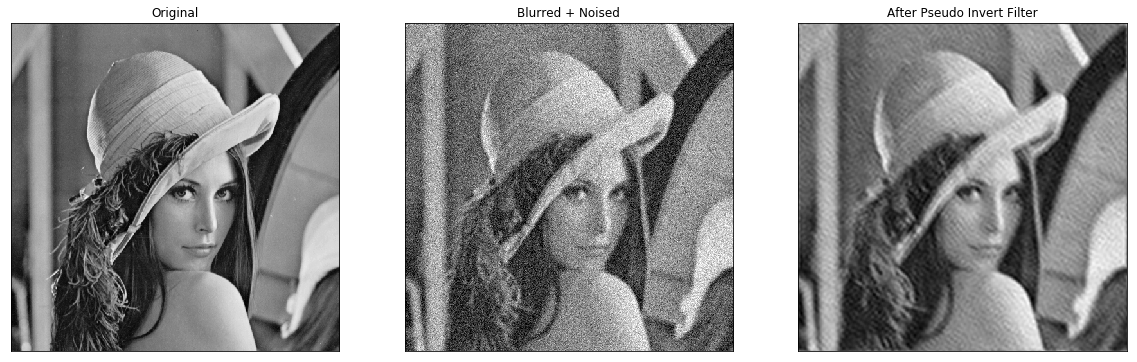

In [8]:
denoise_pseudo_img = PseudoInvertFilter(noise,filter_blur, 0.5)

plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(noise, cmap='gray'),plt.title('Blurred + Noised')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(denoise_pseudo_img, cmap='gray'),plt.title('After Pseudo Invert Filter')
plt.xticks([]), plt.yticks([])
plt.show()

2. Fix the parameter $\epsilon = 0.5$.
Plot the graph of the Root Mean Square (RMS) error of restoration (Y axis) versus the
variance of the noise $\sigma_n^2$ (X axis).


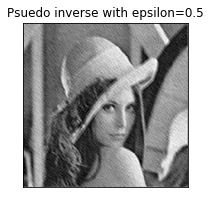

C:\Users\matan\Anaconda2\envs\bluebanana\lib\site-packages\ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


RMS of restoration vs. noise variance


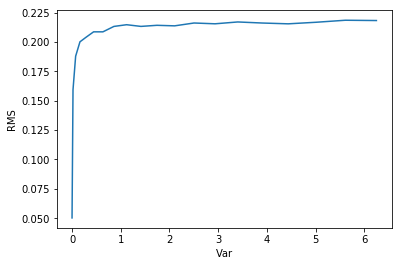

In [179]:
plt.figure(figsize=(10,10))
plt.subplot(131),plt.imshow(denoise_pseudo_img, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title("Psuedo inverse with epsilon=0.5")
plt.show()

def ImageBlurreVariance(img, filter_blur,sigma):
    img_blurre_noise_variance = util.random_noise(img, var=np.power(sigma, 2))
    return img_blurre_noise_variance

img_blurre = cv2.filter2D(img,-1,filter_blur)

m,n = img.shape
rms=[]
sigma = np.linspace(0.01,2.5,20)
for i in range(len(sigma)):
    img_blurre_noise_variance = ImageBlurreVariance(img_blurre, filter_blur,i)
    img1=PseudoInvertFilter(img_blurre_noise_variance ,filter_blur, 0.5)
    rms.append(np.sqrt(((np.power((img1-img), 2)).sum())/(m*n)))

print("RMS of restoration vs. noise variance")
plt.plot(np.power(sigma, 2), rms)
plt.xlabel('Var')
plt.ylabel('RMS')
plt.show()


   2.1. For what maximal value of the variance of noise you still get an acceptable restoration?

```
The maximal value is the lowest value that still has the minimal RMS, which is about 0.1
```

### Part 3 - Wiener Filter

1. Test the restoration with the Wiener Filter for deblurring and denoising

Assume that the variance used in the Wiener filter formula is equal to the variance of the noise $\sigma_n^2$
, and both of them are equal to 0.01 (for image in a range of 0-1) or 0.01 ∗ 255
(for image in a range of 0-255).

In [135]:
def WienerFilter(noise_img,filter_blur,sigma=0.01, alpha=0.095):
    m, n = noise_img.shape
    H = np.fft.fftshift(np.fft.fft2(filter_blur,s=(n,m)))
    noisy_img_FFT = np.fft.fft2(noise_img)
    var = np.power(sigma, 2)
    x = np.linspace(-m/2,m/2-1, m)
    y = np.linspace(-n/2,n/2-1, n)
    u,v = np.meshgrid(x,y)
    filter_denomiter = np.power(np.abs(H),2) + alpha * var *  (np.power(u,2) + np.power(v,2))
    H_weiner = np.conjugate(H)/filter_denomiter
    denoise_img_freq = np.fft.fftshift(np.fft.fft2(noise_img)) * H_weiner
    denoise_img = np.fft.ifft2(denoise_img_freq)
    denoise_img = np.abs(denoise_img)
    return denoise_img

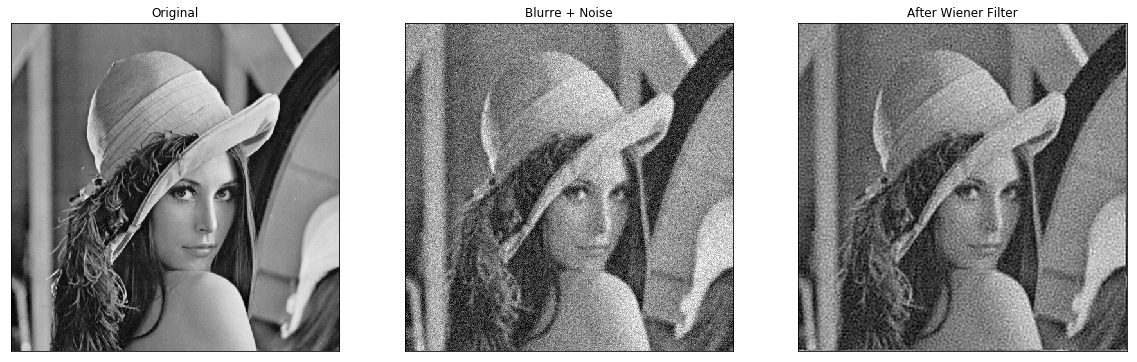

In [136]:
filter_blur = cv2.getGaussianKernel(ksize=5,sigma=1.85)*cv2.getGaussianKernel(ksize=5,sigma=1.85).T 

denoise_wiener_img = WienerFilter(noise,filter_blur)

plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(noise, cmap='gray'),plt.title('Blurre + Noise')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(denoise_wiener_img, cmap='gray'),plt.title('After Wiener Filter')
plt.xticks([]), plt.yticks([])
plt.show()


2. Plot the graph of the Root Mean Square (RMS) error of restoration (Y axis) versus the parameter $\sigma_n^2$ (X axis) (change $\sigma_n$ only in the filter, the noise stay the same, also no need to change alpha). __Show the result of the best restoration.__

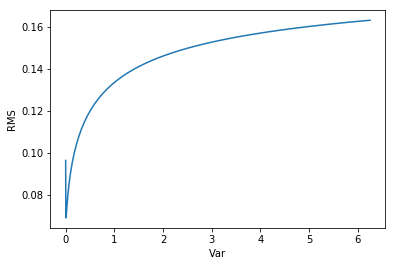

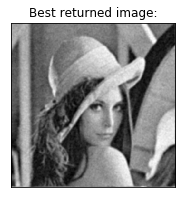

In [176]:
m,n = img.shape
rms=[]
sigma = np.linspace(0.01,2.5,50)

for i in range(len(sigma)):
    img1 = WienerFilter(noise,filter_blur, sigma = sigma[i])
    rms.append(np.sqrt(((np.power((img1-img), 2)).sum())/(m*n)))

plt.plot(np.power(sigma, 2), rms)
plt.xlabel('Var')
plt.ylabel('RMS')
plt.show() 
plt.figure(figsize=(10,10))
ideal = WienerFilter(noise,filter_blur, sigma=sigma[rms.index(min(rms))])
plt.subplot(131),plt.imshow(ideal, cmap='gray'), plt.title('Best returned image:')
plt.xticks([]), plt.yticks([])
plt.show()